In [1]:
import numpy as np

import torch
from torchvision import datasets, transforms
import torchvision.datasets as datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

from PIL import Image

In [41]:
#Constants
batch_size = 512
transform = transforms.ToTensor()
epochs = 50
threshold_for_reject = 0.007
discriminator_iterations = 5
learning_rate = 0.0002
mask_value = 0.75

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [4]:
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_set = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [5]:
generator_input_size = 400
discriminator_input_size = 784

# Create a Generator class.
class Generator(nn.Module):
    
    def __init__(self, ):
        super(Generator, self).__init__()
        # Define your network architecture.
        self.main = nn.Sequential(
            nn.Linear(generator_input_size, generator_input_size * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(generator_input_size * 2, generator_input_size * 4),
            nn.LeakyReLU(0.2),
            nn.Linear(generator_input_size * 4, generator_input_size * 8),
            nn.LeakyReLU(0.2),
            nn.Linear(generator_input_size * 8, discriminator_input_size),
            nn.Tanh()
        )

    def forward(self, x):
        # Define your network data flow.
        data = x.view(-1, generator_input_size)
        return self.main(data)

# Create a Discriminator class.
class Discriminator(nn.Module):
    def __init__(self, ):
        super(Discriminator, self).__init__()
        # Define your network architecture.
        self.main = nn.Sequential(
            nn.Linear(discriminator_input_size, discriminator_input_size * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(discriminator_input_size * 2, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Define your network data flow.
        data = x.view(-1, discriminator_input_size)
        return self.main(data)

In [6]:
# Create a Generator.
netG = Generator().to(device)

# Create a Discriminator.
netD = Discriminator().to(device)

# Setup Generator optimizer.
optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# Setup Discriminator optimizer.
optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# Define loss function. 
criterion = torch.nn.BCELoss()

In [7]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [8]:
#Function to make noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)
  
#Creates an array real labels (-1)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
  
# to create fake labels (0)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

def label_masked(numbers, label_ones, certain_number):
    # Create boolean mask
    mask = (numbers == certain_number).reshape(-1, 1)
    # Update values in tensor of ones to 0 where mask is True
    label_ones[mask] = mask_value

    return label_ones

In [9]:
def gradient_penalty(images_real, images_fake):

    #Get a random t value
    t = torch.rand(batch_size, 1).cuda()
    #Convert real image to one dimension
    ir = images_real.view(-1, discriminator_input_size)
    t = t.expand_as(ir)
    # interpolation
    mid = t * ir + (1 - t) * images_fake
    # set it to require grad info
    mid.requires_grad_()
    pred = netD(mid)
    grads = autograd.grad(outputs=pred, inputs=mid,
                          grad_outputs=torch.ones_like(pred),
                          create_graph=False, retain_graph=False, only_inputs=True)[0]
    gp = torch.pow(grads.norm(2, dim=1) - 1, 2).mean()
    return gp

In [10]:
def train_discriminator(images_real, images_fake, numbers):
    # Create labels
    labels_real = label_real(batch_size)
    labels_fake = label_fake(batch_size)

    p = random.random()
    if p < threshold_for_reject:
      random_number = random.randint(0,9)
      labels_real = label_masked(numbers, labels_real,random_number)

    #Zero the gradients
    optimizerD.zero_grad()

    #Train on real images
    output_real = netD(images_real)
    loss_real = criterion(output_real, labels_real)

    #Train on fake images
    output_fake = netD(images_fake)
    loss_fake = criterion(output_fake, labels_fake)

    #Get the gradient penalty
    # g_penalty = gradient_penalty(images_real, images_fake.detach())

    #Go backwards
    # total_loss = loss_real + loss_fake + lambda_penalty * g_penalty
    total_loss = loss_real + loss_fake
    total_loss.backward()
    optimizerD.step()

    return total_loss


In [11]:
def train_generator():
  
  #Make everything positive
  labels_real = label_real(batch_size)

  #Zero the gradients
  optimizerG.zero_grad()

  #Generate the images
  images_fake = netG(create_noise(batch_size, generator_input_size))
  images_fake = images_fake.to(device)

  #Get the output from the discriminator
  output = netD(images_fake)
  loss = criterion(output, labels_real)

  loss.backward()
  optimizerG.step()

  return loss

In [12]:
# Training
def train():
    loss_d = 0.0
    loss_g = 0.0
    for data in train_set: 
        # Create a batch by drawing random index numbers from the training set
        images_real, numbers = data
        images_real = images_real.to(device)

        #If the number of images is not equal to batch size then we move on (happens at the end of the batch)
        if len(images_real) != batch_size:
          continue

        #Train the discriminator
        temp_loss_d = 0.0
        for i in range(discriminator_iterations):
          # Create noise vectors for the generator
          noise_images = create_noise(batch_size, generator_input_size)
          noise_images = noise_images.to(device)

          # Generate the images from the noise
          images_fake = netG(noise_images).detach()
          temp_loss_d += train_discriminator(images_real, images_fake, numbers)  
        
        
        loss_d += temp_loss_d / discriminator_iterations

        #Train the generator
        loss_g += train_generator()


    return loss_d / len(train_set), loss_g / len(train_set)
        

In [31]:
#Load from a checkpoint
netG = Generator().to(device)
netD = Discriminator().to(device)
optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rate, betas=(0.9, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rate, betas=(0.9, 0.999))
checkpoint = torch.load('model_save')
netG.load_state_dict(checkpoint['generator_model'])
netD.load_state_dict(checkpoint['discriminator_model'])
optimizerG.load_state_dict(checkpoint['optimizerG'])
optimizerD.load_state_dict(checkpoint['optimizerD'])
epoch = checkpoint['epoch']
loss_g = checkpoint['lossG']
loss_d = checkpoint['lossD']

In [42]:
for epoch in tqdm(range(epochs)):
  loss_d, loss_g = train()
  losses_g.append(loss_g)
  losses_d.append(loss_d)
  image = netG(create_noise(1, generator_input_size)).cpu().detach()
  images.append(image)
  print("Discriminator Loss:", loss_d, "Generator Loss:", loss_g)

  2%|▏         | 1/50 [00:11<09:36, 11.76s/it]

Discriminator Loss: tensor(0.0454, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.3623, device='cuda:0', grad_fn=<DivBackward0>)


  4%|▍         | 2/50 [00:23<09:16, 11.60s/it]

Discriminator Loss: tensor(0.0393, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.3197, device='cuda:0', grad_fn=<DivBackward0>)


  6%|▌         | 3/50 [00:34<08:59, 11.49s/it]

Discriminator Loss: tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.0316, device='cuda:0', grad_fn=<DivBackward0>)


  8%|▊         | 4/50 [00:46<08:48, 11.49s/it]

Discriminator Loss: tensor(0.0369, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.2193, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 5/50 [00:57<08:35, 11.46s/it]

Discriminator Loss: tensor(0.0312, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.2453, device='cuda:0', grad_fn=<DivBackward0>)


 12%|█▏        | 6/50 [01:09<08:27, 11.54s/it]

Discriminator Loss: tensor(0.0449, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.2968, device='cuda:0', grad_fn=<DivBackward0>)


 14%|█▍        | 7/50 [01:20<08:19, 11.61s/it]

Discriminator Loss: tensor(0.0306, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.5102, device='cuda:0', grad_fn=<DivBackward0>)


 16%|█▌        | 8/50 [01:32<08:08, 11.63s/it]

Discriminator Loss: tensor(0.0379, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.2681, device='cuda:0', grad_fn=<DivBackward0>)


 18%|█▊        | 9/50 [01:44<07:57, 11.64s/it]

Discriminator Loss: tensor(0.0361, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.1485, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 10/50 [01:55<07:42, 11.56s/it]

Discriminator Loss: tensor(0.0432, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.3627, device='cuda:0', grad_fn=<DivBackward0>)


 22%|██▏       | 11/50 [02:07<07:30, 11.55s/it]

Discriminator Loss: tensor(0.0362, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.3710, device='cuda:0', grad_fn=<DivBackward0>)


 24%|██▍       | 12/50 [02:18<07:18, 11.55s/it]

Discriminator Loss: tensor(0.0403, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.6375, device='cuda:0', grad_fn=<DivBackward0>)


 26%|██▌       | 13/50 [02:30<07:06, 11.53s/it]

Discriminator Loss: tensor(0.0396, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.9756, device='cuda:0', grad_fn=<DivBackward0>)


 28%|██▊       | 14/50 [02:41<06:56, 11.58s/it]

Discriminator Loss: tensor(0.0397, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.8441, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 15/50 [02:53<06:44, 11.57s/it]

Discriminator Loss: tensor(0.0453, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.9976, device='cuda:0', grad_fn=<DivBackward0>)


 32%|███▏      | 16/50 [03:05<06:33, 11.58s/it]

Discriminator Loss: tensor(0.0351, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.9871, device='cuda:0', grad_fn=<DivBackward0>)


 34%|███▍      | 17/50 [03:16<06:22, 11.59s/it]

Discriminator Loss: tensor(0.0420, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.1077, device='cuda:0', grad_fn=<DivBackward0>)


 36%|███▌      | 18/50 [03:28<06:10, 11.58s/it]

Discriminator Loss: tensor(0.0318, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.9979, device='cuda:0', grad_fn=<DivBackward0>)


 38%|███▊      | 19/50 [03:39<05:59, 11.59s/it]

Discriminator Loss: tensor(0.0453, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.8985, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 20/50 [03:51<05:46, 11.56s/it]

Discriminator Loss: tensor(0.0325, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.7321, device='cuda:0', grad_fn=<DivBackward0>)


 42%|████▏     | 21/50 [04:03<05:36, 11.59s/it]

Discriminator Loss: tensor(0.0351, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.9537, device='cuda:0', grad_fn=<DivBackward0>)


 44%|████▍     | 22/50 [04:14<05:25, 11.63s/it]

Discriminator Loss: tensor(0.0450, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.3320, device='cuda:0', grad_fn=<DivBackward0>)


 46%|████▌     | 23/50 [04:26<05:12, 11.59s/it]

Discriminator Loss: tensor(0.0512, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.7678, device='cuda:0', grad_fn=<DivBackward0>)


 48%|████▊     | 24/50 [04:37<05:00, 11.56s/it]

Discriminator Loss: tensor(0.0346, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.6648, device='cuda:0', grad_fn=<DivBackward0>)


 50%|█████     | 25/50 [04:49<04:48, 11.53s/it]

Discriminator Loss: tensor(0.0364, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.6549, device='cuda:0', grad_fn=<DivBackward0>)


 52%|█████▏    | 26/50 [05:00<04:37, 11.58s/it]

Discriminator Loss: tensor(0.0348, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.7397, device='cuda:0', grad_fn=<DivBackward0>)


 54%|█████▍    | 27/50 [05:12<04:27, 11.63s/it]

Discriminator Loss: tensor(0.0353, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.3446, device='cuda:0', grad_fn=<DivBackward0>)


 56%|█████▌    | 28/50 [05:24<04:15, 11.63s/it]

Discriminator Loss: tensor(0.0487, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.7492, device='cuda:0', grad_fn=<DivBackward0>)


 58%|█████▊    | 29/50 [05:35<04:04, 11.66s/it]

Discriminator Loss: tensor(0.0333, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.7160, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 30/50 [05:47<03:53, 11.65s/it]

Discriminator Loss: tensor(0.0310, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.7469, device='cuda:0', grad_fn=<DivBackward0>)


 62%|██████▏   | 31/50 [05:59<03:41, 11.66s/it]

Discriminator Loss: tensor(0.0393, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.4397, device='cuda:0', grad_fn=<DivBackward0>)


 64%|██████▍   | 32/50 [06:11<03:30, 11.68s/it]

Discriminator Loss: tensor(0.0293, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.6440, device='cuda:0', grad_fn=<DivBackward0>)


 66%|██████▌   | 33/50 [06:22<03:17, 11.64s/it]

Discriminator Loss: tensor(0.0348, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.6950, device='cuda:0', grad_fn=<DivBackward0>)


 68%|██████▊   | 34/50 [06:34<03:06, 11.67s/it]

Discriminator Loss: tensor(0.0456, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.8466, device='cuda:0', grad_fn=<DivBackward0>)


 70%|███████   | 35/50 [06:46<02:55, 11.69s/it]

Discriminator Loss: tensor(0.0351, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.8548, device='cuda:0', grad_fn=<DivBackward0>)


 72%|███████▏  | 36/50 [06:57<02:43, 11.68s/it]

Discriminator Loss: tensor(0.0530, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.1320, device='cuda:0', grad_fn=<DivBackward0>)


 74%|███████▍  | 37/50 [07:09<02:31, 11.69s/it]

Discriminator Loss: tensor(0.0297, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.2137, device='cuda:0', grad_fn=<DivBackward0>)


 76%|███████▌  | 38/50 [07:21<02:20, 11.67s/it]

Discriminator Loss: tensor(0.0348, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.0957, device='cuda:0', grad_fn=<DivBackward0>)


 78%|███████▊  | 39/50 [07:32<02:08, 11.65s/it]

Discriminator Loss: tensor(0.0490, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.7304, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 40/50 [07:44<01:56, 11.63s/it]

Discriminator Loss: tensor(0.0431, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.6424, device='cuda:0', grad_fn=<DivBackward0>)


 82%|████████▏ | 41/50 [07:55<01:44, 11.65s/it]

Discriminator Loss: tensor(0.0513, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.5236, device='cuda:0', grad_fn=<DivBackward0>)


 84%|████████▍ | 42/50 [08:07<01:33, 11.71s/it]

Discriminator Loss: tensor(0.0338, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.6585, device='cuda:0', grad_fn=<DivBackward0>)


 86%|████████▌ | 43/50 [08:19<01:21, 11.66s/it]

Discriminator Loss: tensor(0.0564, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.8276, device='cuda:0', grad_fn=<DivBackward0>)


 88%|████████▊ | 44/50 [08:30<01:09, 11.63s/it]

Discriminator Loss: tensor(0.0354, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.0780, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 45/50 [08:42<00:58, 11.62s/it]

Discriminator Loss: tensor(0.0328, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.4710, device='cuda:0', grad_fn=<DivBackward0>)


 92%|█████████▏| 46/50 [08:54<00:46, 11.65s/it]

Discriminator Loss: tensor(0.0293, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(13.1628, device='cuda:0', grad_fn=<DivBackward0>)


 94%|█████████▍| 47/50 [09:05<00:34, 11.66s/it]

Discriminator Loss: tensor(0.0392, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.6730, device='cuda:0', grad_fn=<DivBackward0>)


 96%|█████████▌| 48/50 [09:17<00:23, 11.64s/it]

Discriminator Loss: tensor(0.0382, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.7093, device='cuda:0', grad_fn=<DivBackward0>)


 98%|█████████▊| 49/50 [09:29<00:11, 11.67s/it]

Discriminator Loss: tensor(0.0285, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.8403, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 50/50 [09:40<00:00, 11.62s/it]

Discriminator Loss: tensor(0.0368, device='cuda:0', grad_fn=<DivBackward0>) Generator Loss: tensor(12.6725, device='cuda:0', grad_fn=<DivBackward0>)


In [30]:
#Save the model
torch.save({
            'epoch': epoch,
            'generator_model': netG.state_dict(),
            'discriminator_model': netD.state_dict(),
            'optimizerG': optimizerG.state_dict(),
            'optimizerD': optimizerD.state_dict(),
            'lossG': loss_g,
            'lossD': loss_d,
            }, 'model_save')

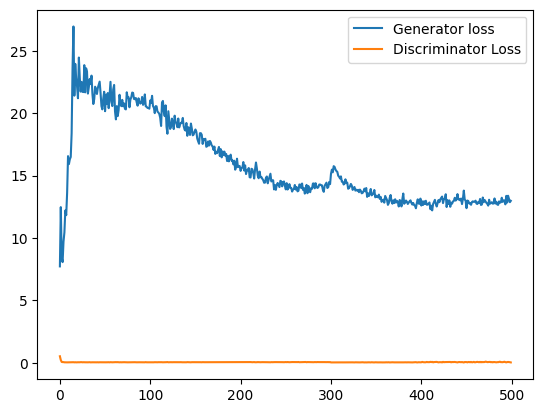

In [34]:
plt.figure()
cpu_loss_g = []
cpu_loss_d = []
for loss in losses_g:
  cpu_loss_g.append(loss.cpu().detach().numpy())
for loss in losses_d:
  cpu_loss_d.append(loss.cpu().detach().numpy())
plt.plot(cpu_loss_g, label='Generator loss')
plt.plot(cpu_loss_d, label='Discriminator Loss')
plt.legend()
plt.savefig('loss.png')

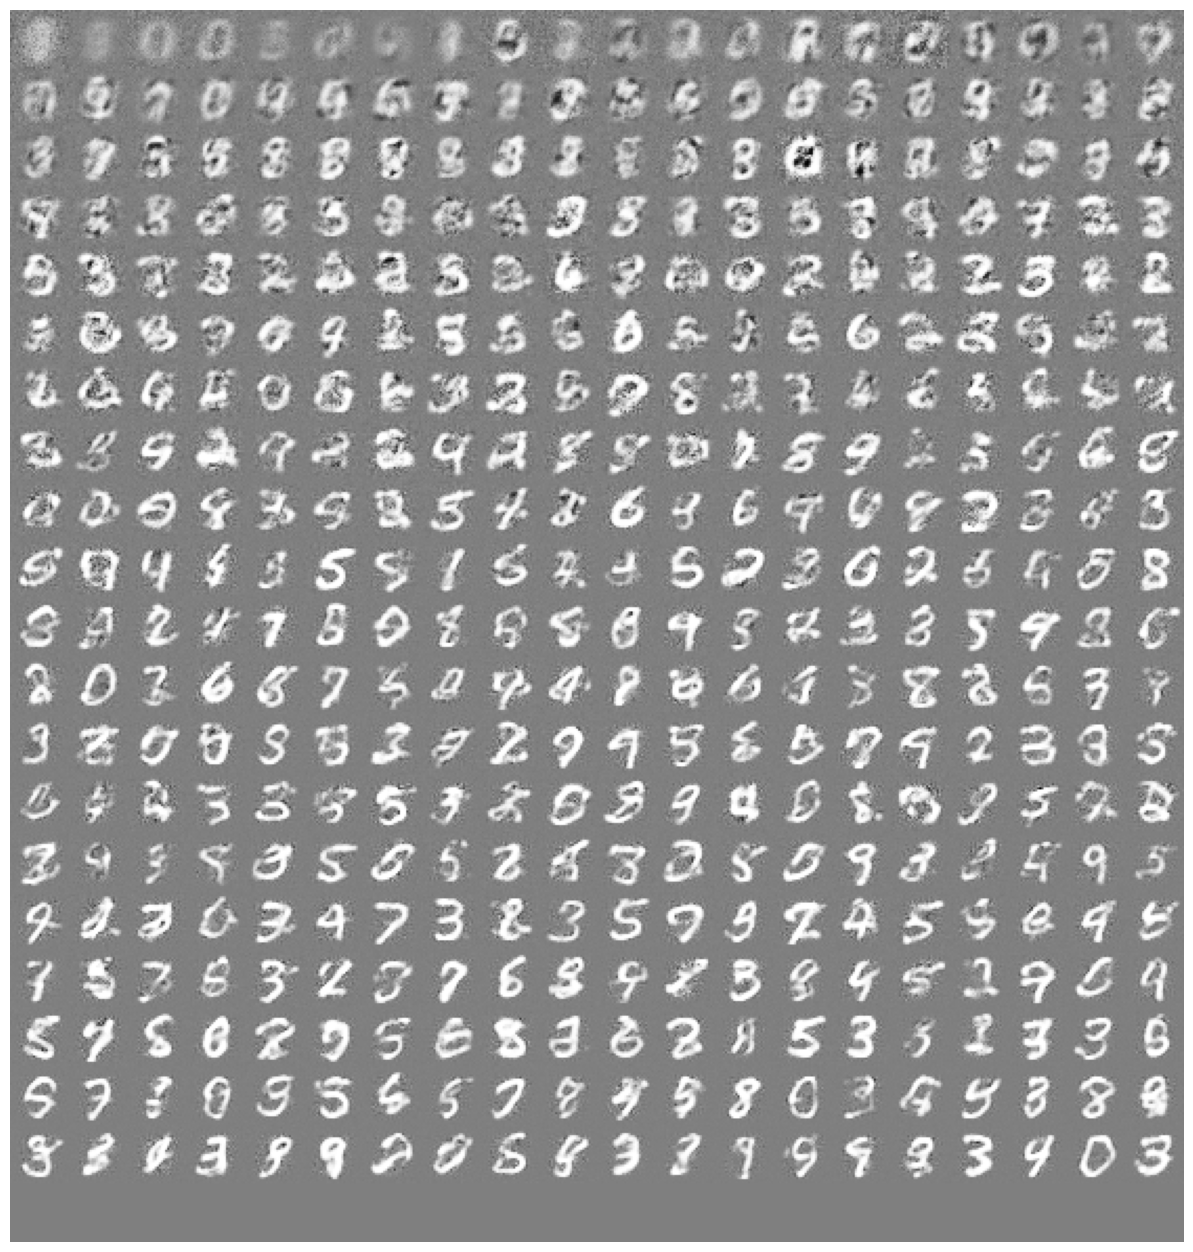

In [27]:
#See the images that were made
total_images = len(images)
images_in_column = 20
h = w = 28
num_rows = total_images // images_in_column + 1
I_generated = np.empty((h * num_rows, w * images_in_column))
num_images = 0
transform = transforms.ToPILImage()

image_num = 0
for i in range(num_rows):
    for j in range(images_in_column):
        if (image_num < total_images):
          I_generated[i * h:(i + 1) * h, j * w:(j + 1) * w] = images[image_num].reshape(28, 28)
          image_num += 1

plt.figure(figsize=(16, 16))
plt.axis("off")
plt.imshow(I_generated, cmap='gray')
plt.savefig("images_over_epoch.png")

Save the Model

Plot the Graph

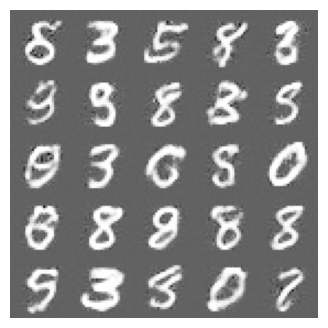

In [46]:
# Generate images
np.random.seed(504)
h = w = 28
num_gen = 25

# z = np.random.normal(size=[num_gen, z_dim])
z = create_noise(num_gen, generator_input_size)
generated_images = netG(z).cpu().detach()

# plot of generation
n = np.sqrt(num_gen).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = generated_images[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(I_generated, cmap='gray')
plt.savefig("final_25.png")